# BHARAT INTERN TASK 1: Stock Prediction with LSTM

To start, let me explain what we're aiming to do. We're going to use LSTM, a type of neural network, to predict future stock prices based on historical data. LSTM is particularly useful for this task because it can capture patterns in sequential data, like time-series data such as stock prices.

### Importing Libraries

In [70]:
#1. Importing necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler 
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

#2. Suppress warnings
import warnings
warnings.filterwarnings('ignore')


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_5360\3134005389.py", line 10, in <module>
    from tensorflow.keras.models import Sequential
  File "C:\Users\PC\anaconda3\Lib\site-packages\keras\api\_v2\keras\__init__.py", line 3, in <module>
    from keras.api._v2.keras import __internal__
  File "C:\Users\PC\anaconda3\Lib\site-packages\keras\api\_v2\keras\__init__.py", line 3, in <module>
    from keras.api._v2.keras import __internal__
  File "C:\Users\PC\anaconda3\Lib\site-packages\keras\api\_v2\keras\__internal__\__init__.py", line 3, in <module>
    from keras.api._v2.keras.__internal__ import backend
  File "C:\Users\PC\anaconda3\Lib\site-packages\keras\api\_v2\keras\__internal__\backend\__init__.py", line 3, in <module>
    from keras.src.backend import _initialize_variables as initial

### Data Preprocessing:

In [4]:
#3. Download data using Yahoo finance API

In [2]:
df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2012-01-01") & (df['Date'] <= "2024-06-24")].reset_index(drop=True)

[*********************100%%**********************]  1 of 1 completed


In [10]:
#4. Load Data and View basic information

In [3]:
df.head(n=11)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
1,2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2,2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
3,2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
4,2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
5,2012-01-10,1.829333,1.850667,1.816667,1.841333,1.841333,10077000
6,2012-01-11,1.841333,1.892000,1.820000,1.882000,1.882000,10084500
7,2012-01-12,1.898667,1.908000,1.854000,1.883333,1.883333,10939500
8,2012-01-13,1.893333,1.900000,1.509333,1.519333,1.519333,82506000
9,2012-01-17,1.774667,1.822667,1.760667,1.773333,1.773333,69774000


In [7]:
df.shape

(3128, 7)

In [8]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3128,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3.128000e+03
mean,2018-03-21 14:31:55.089513984,82.925367,84.727733,80.986794,82.898796,82.898796,1.061133e+08
min,2012-01-03 00:00:00,1.774667,1.790000,1.509333,1.519333,1.519333,5.473500e+06
25%,2015-02-11 18:00:00,13.963000,14.220833,13.748333,13.923833,13.923833,5.916075e+07
50%,2018-03-21 12:00:00,19.863333,20.263332,19.486667,19.866666,19.866666,8.916315e+07
75%,2021-04-29 06:00:00,176.224998,180.049995,173.565002,177.465004,177.465004,1.287229e+08
max,2024-06-07 00:00:00,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08
std,NaN,104.674739,106.981375,102.133304,104.586604,104.586604,7.821339e+07


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3128 non-null   datetime64[ns]
 1   Open       3128 non-null   float64       
 2   High       3128 non-null   float64       
 3   Low        3128 non-null   float64       
 4   Close      3128 non-null   float64       
 5   Adj Close  3128 non-null   float64       
 6   Volume     3128 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 171.2 KB


In [11]:
#5. Check for missing values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [24]:
#6 Scaling the Closing Price
# Using MinMaxScaler formula: y = (y - min(y)) / (max(y) - min(y))
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))


### Data Splitting 

In [26]:
# Splitting data into train and test sets
train_data = df[df['Date'] < '2023-01-01']
test_data = df[df['Date'] >= '2023-01-01']

###  Data Visualization

In [12]:
#7. Data Visualization

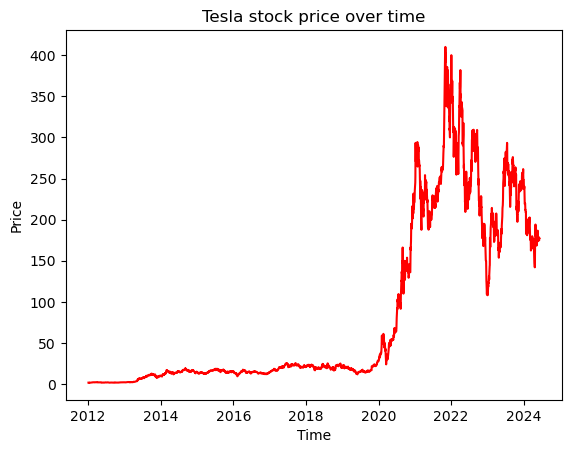

In [17]:
#7.1 Tesla Stock Chart 2012-2023
plt.plot(df["Date"], df["Close"], color='red')  
plt.title("Tesla stock price over time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


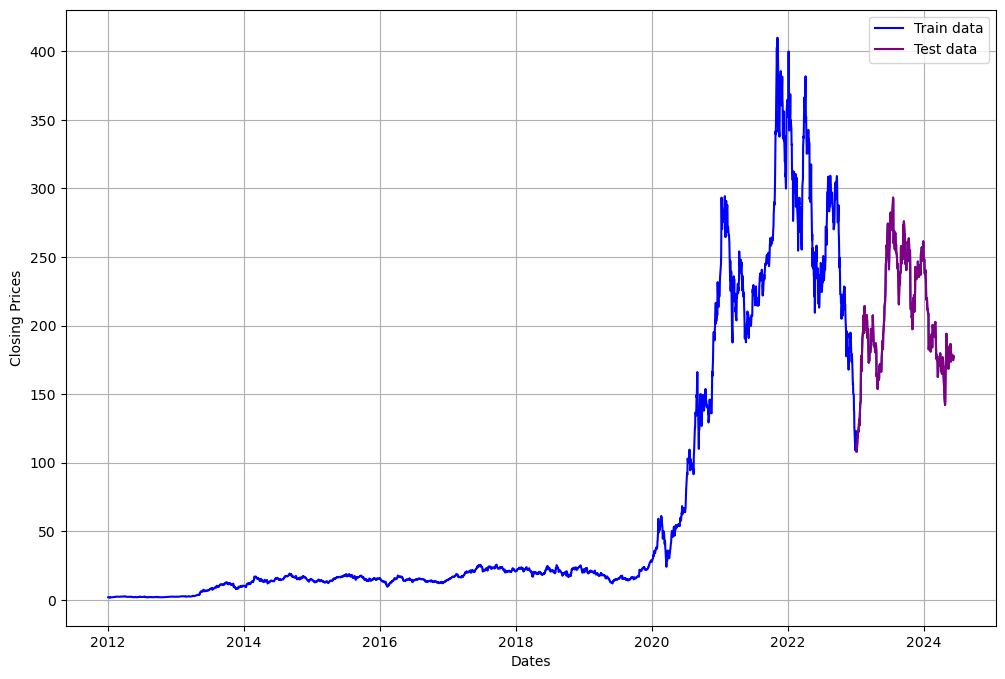

In [37]:
#7.2 Tesla Stock Price Chart
# Plotting the data
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'], df['Close'], color='blue', label='Train data')  # Changing color to orange for train data
plt.plot(test_data['Date'], test_data['Close'], color='purple', label='Test data')  # Changing color to purple for test data
plt.legend()
plt.show()

### Data Preparation

In [49]:
#8.1 Data Preparation for LSTM Model Training
x_train = []
y_train = []

for i in range(90, len(train_data['scaled_values'])):  # Changed range from 60 to 90
    x_train.append(train_data['scaled_values'][i-90:i])  # Changed window size from 60 to 90
    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [50]:
#8.2 Data Preparation for LSTM Model Testing

x_test = []
y_test = test_data['scaled_values']

for i in range(90, len(test_data)):  # Using a window size of 90
    x_test.append(test_data['scaled_values'][i-90:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


### Model Building

In [68]:
hiddenimports=['tensorflow.python.keras.engine.base_layer_v1']

In [69]:
# Model Architecture Definition for LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.summary()


ModuleNotFoundError: No module named 'keras.engine.base_layer_v1'

In [ ]:
#Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Model Training

In [ ]:
#Fit the model on the training data
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

In [ ]:
# Predict on test data
predicted_test_data = model.predict(x_test)
predicted_test_data = scaler.inverse_transform(predicted_test_data)


### Model Evaluation

In [ ]:
# Data Preparation for LSTM Model Testing

x_test = []
y_test = test_data['scaled_values']

for i in range(90, len(test_data)):  # Using a window size of 90
    x_test.append(test_data['scaled_values'][i-90:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
#Performance Metrics
from sklearn.metrics import mean_absolute_error
import math

y_true = test_data[90:]['Close'].values
y_pred = predicted_stock_price

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))